<a id="top"></a>
# Landsat Vegetation Phenology <img align="right" style="padding:10px" src="../images/odc_logo.png">

This notebook calculates vegetation phenology changes using Landsat 7 or Landsat 8 data. To detect changes, the algorithm uses Normalized Difference Vegetation Index (NDVI) which is a common proxy for vegetation growth and health. The outputs of this notebook can be used to assess differences in agriculture fields over time or space and also allow the assessment of growing states such as planting and harvesting.  
<br>
There are two output products. The first output product is a time series boxplot of NDVI with the data binned by week, month, week of year, or month of year. The second output product is a time series lineplot of the mean NDVI for each year, with the data potentially binned by week or month. This product is useful for comparing years to each other.
<br><br>
Finally, the annual NDVI curves are analyzed using TIMESAT to calculate the seasonality parameters: (a) beginning of season, (b) end of season, (c) middle of season, (d) length of season, (e) base value, (f) maximum value, (g) amplitude. These parameters are often used by agriculture scientists.

What does this Notebook do?
* [Setup the Environment](#environment_setup)
* [Choose Platforms and Products](#platforms_products)
* [Define Anlaysis Parameters](#define_analysis_params)
* [Load Data from the Data Cube and Obtain the Vegetation Proxy](#load_data)
* [Create a Mosaic for the Baseline and Analysis Time Periods](#create_mosaic)
* [Calculate Anomaly Product](#anomalies)
* [Show Baseline RGB, Analysis RGB and Anomaly Products](#plots)
* [Calculate Pixel Counts within Thresholds](#calculate_pixels)
* [Contributors, Heritage and References](#contributors_heritage)

This notebook uses external functions including both a standard set of DCAL utilities (see folder [DCAL_utils](../DCAL_utils)) and a code behind file containing some specalised functions that make this page work (see file [DCAL_Vegetation_Phenology.py](DCAL_Vegetation_Phenology.py)).

<i><p style="color:red"><b>Red Text:</b> Indicates code blocks where user inputs can be provided.</p></i>

<a id="environment_setup"></a>
## Environment Setup [&#9652;](#top)
* **Surpress Python Warnings:** These warnings include notes about deprecitation of Python modules, etc.
* **Import Standard Python Modules:** Import external and standard Python modules including `datacube` which is part of the ODC framework, as well as `xarray` which is a useful external module.
* **Import DCAL Utilities:** Import a set of utilities developed by the DCAL team to help automate some of the more routine tasks in the notebooks. These utilities are located in `/DCAL_utils`.
* **Initialize Data Cube and Data Cube API**

[Back to Top](#top)## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span> 

In [1]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Standard Python Modules
import datacube
import sys
import numpy as np  
import xarray as xr  
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import os
from calendar import monthrange
from xarray.ufuncs import isnan as xr_nan

In [3]:
# Import notebook code behind (as cb) contaning function definitions specific to this notebook
import DCAL_Vegetation_Phenology as cb

# Add parent folder to the sys.path
# This means the import path has to be explicit to differentate between utils versions; OK work around
# Eventually DCAL_utils and DCAL_utils_special will need to be reconciled
sys.path.append('..') 

# Import DCAL utilities containing function definitions used generally across DCAL
# Import Data Cube API.
import DCAL_utils.data_access_api as dc_api

# Import overlapping area function
from DCAL_utils.dc_load import get_overlapping_area

# Import date time function
from DCAL_utils.dc_time import dt_to_str

# Import display map functions
from DCAL_utils.dc_display_map import display_map

# Import clean mask functions
from DCAL_utils.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid

# Import xarray sort function
from DCAL_utils.sort import xarray_sortby_coord

# Import time functions
from DCAL_utils.dc_time import _n64_datetime_to_scalar, _scalar_to_n64_datetime

# Import DCAL utilities SPECIAL containing SPECIAL versions of function definitions used generally across DCAL (temp fix, pending reconciliation)
# Import SPECIAL dc_load matching dim sizes function
from DCAL_utils_special.dc_load import match_dim_sizes

# Import SPECIAL dc_load is dataset empty function
from DCAL_utils_special.dc_load import is_dataset_empty

# Import SPECIAL aggregate xarray resolution scaling function
from DCAL_utils_special.aggregate import xr_scale_res

# Import SPECIAL NDVI function
from DCAL_utils_special.vegetation import NDVI

# Import SPECIAL plotter utils
from DCAL_utils_special.plotter_utils import xarray_time_series_plot

# Import gaussian filter fit function
from DCAL_utils_special.curve_fitting import gaussian_filter_fit

In [4]:
# Initialize Data Cube (dc) and Data Cube API (api).
api = dc_api.DataAccessApi()
dc = api.dc

<a id="platforms_products"></a>
## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>
* **Select Product:** Specify the product you desire to use. Note you can see the complete list of products in this Cube in the introductory notebook (<a href="../Open%20Data%20Cube%20Application%20Library%20Notebooks.ipynb#products" target="_blank">click here</a>).
* **View Dataset Spatial and Temporal Extents:** Queries the Cube and displays the min/max latitude and longitude, and the start and end date and time.
* **Select Spatial and Temporal Extents:** Select the area of interest (AOI) and time range based on extents available.

[Back to Top](#top)

In [5]:
# Select Products and Platforms
# It is possible to select multiple datasets (L7, L8)
# True = SELECT
# False = DO NOT SELECT
# Possible cubes are: kenya, ghana, senegal, tanzania, sierra_leone

use_Landsat7 = True
use_Landsat8 = True
platforms, products = [], []
if use_Landsat7:
    platforms.append('LANDSAT_7')
    products.append('ls7_ledaps_ghana')
if use_Landsat8:
    platforms.append('LANDSAT_8')
    products.append('ls8_lasrc_ghana')

veg_proxy = 'NDVI' 

In [6]:
full_lat, full_lon, min_max_dates = get_overlapping_area(api, platforms, products)

# Print the extents of each product.
str_min_max_dates = np.vectorize(dt_to_str)(min_max_dates)
for i, (platform, product) in enumerate(zip(platforms, products)):
    print("For platform {} and product {}:".format(platform, product))
    print("Time Extents:", str_min_max_dates[i])
    print()

# Print the extents of the combined data.
min_start_date_mutual = np.max(min_max_dates[:,0])
max_end_date_mutual = np.min(min_max_dates[:,1])
print("Overlapping Extents:")
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_start_date_mutual, max_end_date_mutual))))

For platform LANDSAT_7 and product ls7_ledaps_ghana:
Time Extents: ['2000-01-01' '2020-01-10']

For platform LANDSAT_8 and product ls8_lasrc_ghana:
Time Extents: ['2013-04-13' '2020-01-27']

Overlapping Extents:
Latitude Extents: (3.772924193304, 11.318772579912)
Longitude Extents: (-3.772924193304, 1.886462096652)
Time Extents: ['2013-04-13', '2020-01-10']


<p style="color:red";><b>Select Spatial Extents:</b> Select the area of interest (AOI) based on extents available.</p>

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Time Period
start_date, end_date = dt.datetime(2015,1,1), dt.datetime(2017,12,31)
time_extents = (start_date, end_date)

# Maize Field in Ghana
# lat = (9.634628, 9.645304)
# lon = (-0.957238, -0.940233)

# Sudan Savanna, Ghana 
lat = (11.1023, 11.1265)
lon = (-0.2487, -0.2213)

In [8]:
# The code below renders a map that can be used to orient yourself with the region.
display_map(lat, lon)

<a id="load_data"></a>
## Load Data from the Data Cube and Obtain the Vegetation Proxy [&#9652;](#top)
* **Load Data:** Load data, clean, and combine.
* **NDVI:** Compute NDVI.

[Back to Top](#top)

In [9]:
measurements = ['red', 'nir', 'pixel_qa']

datasets, clean_masks = {}, {}
matching_abs_res, same_dim_sizes = match_dim_sizes(dc, products, lon, lat)
for platform, product in zip(platforms, products):
    # Load the data.
    dataset = dc.load(platform=platform, product=product, lat=lat, lon=lon, 
                      time=time_extents, measurements=measurements)
    if len(dataset.dims) == 0: # The dataset is empty.
        continue
    # Get the clean masks.
    clean_mask = (landsat_qa_clean_mask(dataset, platform) & 
                  (dataset[measurements[0]] != -9999) & 
                  landsat_clean_mask_invalid(dataset))
    dataset = dataset.drop('pixel_qa')
    # If needed, scale the datasets and clean masks to the same size in the x and y dimensions.
    if not same_dim_sizes:    
        dataset = xr_scale_res(dataset, abs_res=matching_abs_res)
        clean_mask = xr_scale_res(clean_mask.astype(np.uint8), \
                                  abs_res=matching_abs_res).astype(np.bool)
    dataset = dataset.astype(np.float32).where(clean_mask)
    # Collect the dataset and clean mask.
    datasets[platform] = dataset
    clean_masks[platform] = clean_mask
# Combine everything.
if len(datasets) > 0:
    dataset = xarray_sortby_coord(
        xr.concat(list(datasets.values()), dim='time'), coord='time')
    clean_mask = xarray_sortby_coord(
        xr.concat(list(clean_masks.values()), dim='time'), coord='time')
else:
    dataset = xr.Dataset()
    clean_mask = xr.DataArray(np.empty((0,), dtype=np.bool))
del datasets, clean_masks

assert not is_dataset_empty(dataset), "The dataset is empty."

In [10]:
dataset[veg_proxy] = NDVI(dataset)

### <span id="phenology_plot_1">Plot the Vegetation Index Over Time in a Box-and-Whisker Plot [&#9652;](#top)</span>

In [11]:
# Specify whether to plot a curve fit of the vegetation index along time. Input can be either TRUE or FALSE
plot_curve_fit = True
# assert isinstance(plot_curve_fit, bool), "The variable 'plot_curve_fit' must be "\
#                                         "either True or False."

# Specify the target aggregation type of the curve fit. Input can be either 'mean' or 'median'.
curve_fit_target = 'median'
# assert curve_fit_target in ['mean', 'median'], "The variable 'curve_fit_target' must be either "\
#                                               "'mean' or 'median'."

# The maximum number of data points that appear along time in each plot.
# If more than this number of data points need to be plotted, a grid of plots will be created.
max_times_per_plot = 50 

In [12]:
# Select the binning approach for the vegetation index. 
#  None         = do not bin the data
# 'week'        = bin the data by week with an extended time axis
# 'month'       = bin the data by month with an extended time axis
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

bin_by = 'month'

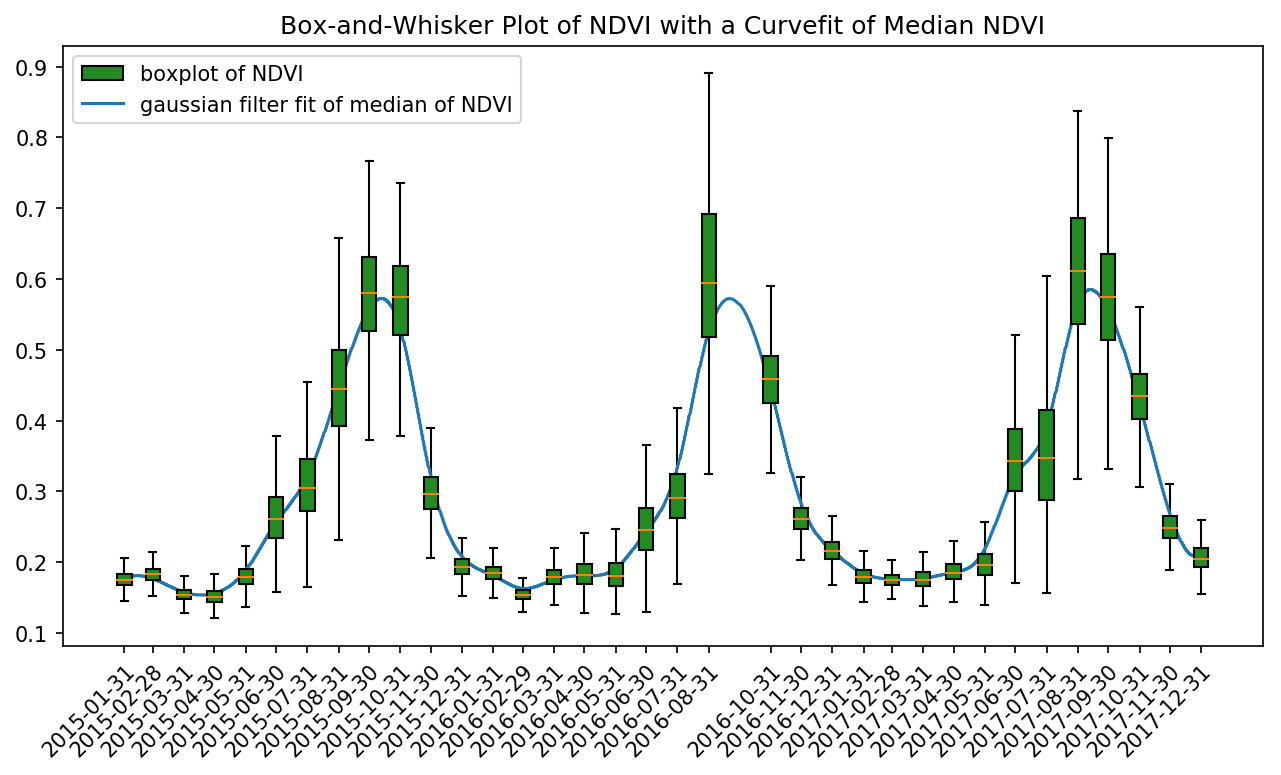

In [13]:
assert bin_by in [None, 'week', 'month', 'weekofyear', 'monthofyear'], \
    "The variable 'bin_by' can only have one of these values: "\
    "[None, 'week', 'month', 'weekofyear', 'monthofyear']"

aggregated_by_str = None
if bin_by is None:
    plotting_data = dataset
elif bin_by == 'week':
    plotting_data = dataset.resample(time='1w').mean()
    aggregated_by_str = 'Week'
elif bin_by == 'month':
    plotting_data = dataset.resample(time='1m').mean()
    aggregated_by_str = 'Month'
elif bin_by == 'weekofyear':
    plotting_data = dataset.groupby('time.week').mean(dim=('time'))
    aggregated_by_str = 'Week of Year'
elif bin_by == 'monthofyear':
    plotting_data = dataset.groupby('time.month').mean(dim=('time'))
    aggregated_by_str = 'Month of Year'
    
params = dict(dataset=plotting_data, plot_descs={veg_proxy:{'none':[
    {'box':{'boxprops':{'facecolor':'forestgreen'}}}]}})
if plot_curve_fit:
    params['plot_descs'][veg_proxy][curve_fit_target] = [{'gaussian_filter':{}}]
    
fig, curve_fit_plotting_data = \
    xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150), 
                            max_times_per_plot=max_times_per_plot)
plt.title('Box-and-Whisker Plot of {1} with a Curvefit of {0} {1}'
          .format(curve_fit_target.capitalize(), veg_proxy))
plt.tight_layout()
plt.show()

### <span id="phenology_plot_2">Plot the Vegetation Index Over Time for Each Year [&#9652;](#top)</span>
Note that the curve fits here do not show where some times have no data (encoded as NaNs), as is shown in the box-and-whisker plot. Notably, the curve fits interpolate over times with missing data that are not the first or last time (e.g. January or December for monthly binned data).

In [14]:
# Select the binning approach for the vegetation index. Set the 'bin_by' parameter.
# 'weekofyear'  = bin the data by week and years using a single year time axis
# 'monthofyear' = bin the data by month and years using a single year time axis

bin_by = 'monthofyear'

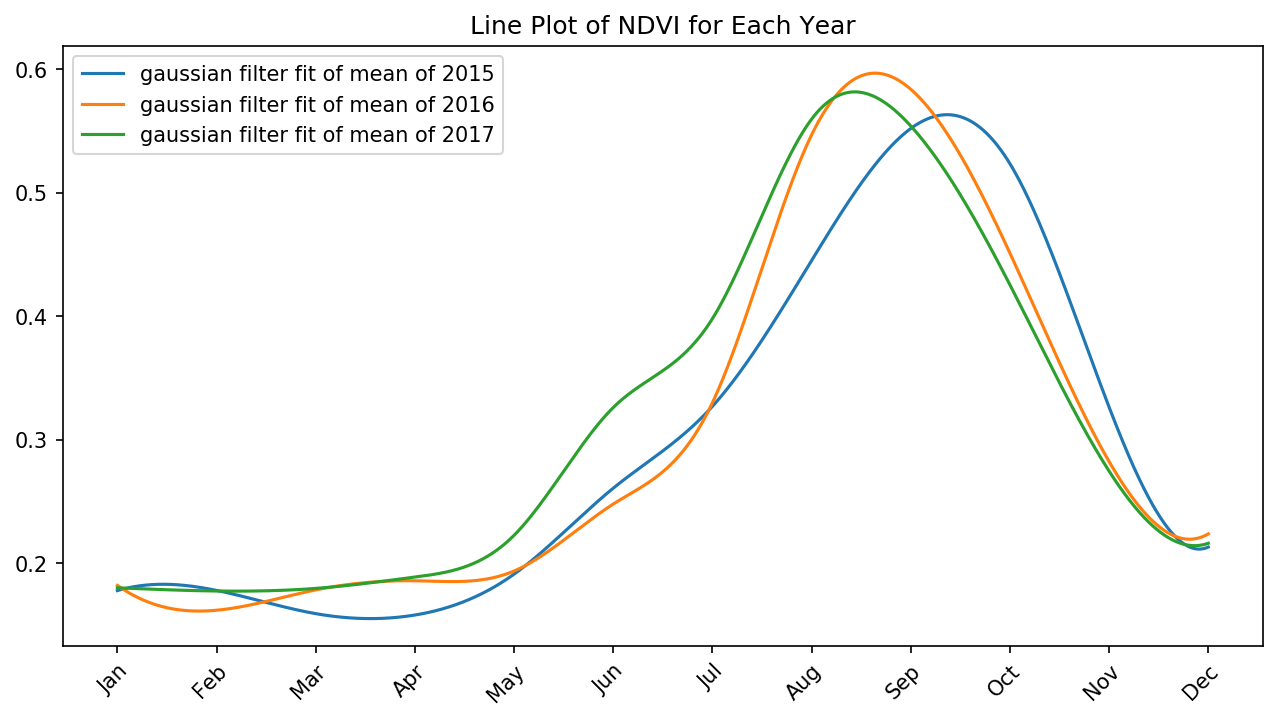

In [15]:
assert bin_by in ['weekofyear', 'monthofyear'], \
    "The variable 'bin_by' can only have one of these values: "\
    "['weekofyear', 'monthofyear']"

years_with_data = []
plot_descs = {}
daysofyear_per_year = {}
plotting_data_years = {}
time_dim_name = None
for year in range(start_date.year, end_date.year+1):
    year_data = dataset.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))[veg_proxy]
    if len(year_data['time']) == 0: # There is nothing to plot for this year.
        print("Year {} has no data, so will not be plotted.".format(year))
        continue
    years_with_data.append(year)
    
    spec_ind_dayofyear = year_data.groupby('time.dayofyear').mean()
    daysofyear_per_year[year] = spec_ind_dayofyear[~spec_ind_dayofyear.isnull()].dayofyear
    
    aggregated_by_str = None
    if bin_by == 'weekofyear':
        plotting_data_year = year_data.groupby('time.week').mean(dim=('time'))
        time_dim_name = 'week'
    elif bin_by == 'monthofyear':
        plotting_data_year = year_data.groupby('time.month').mean(dim=('time'))
        time_dim_name = 'month'

    plotting_data_years[year] = plotting_data_year
    num_time_pts = len(plotting_data_year[time_dim_name])
    
    # Select the curve-fit type. 
    # See the documentation for `xarray_time_series_plot()` regarding the `plot_descs` parameter.
    plot_descs[year] = {'mean':[{'gaussian_filter':{}}]}

time_dim_name = 'week' if bin_by == 'weekofyear' else 'month' if bin_by == 'monthofyear' else 'time'

num_times = 54 if bin_by == 'weekofyear' else 12
time_coords_arr = np.arange(1, num_times+1) # In xarray, week and month indices start at 1.
time_coords_da = xr.DataArray(time_coords_arr, coords={time_dim_name:time_coords_arr}, 
                              dims=[time_dim_name], name=time_dim_name)
coords = dict(list(plotting_data_years.values())[0].coords)
coords[time_dim_name] = time_coords_da 
plotting_data = xr.Dataset(plotting_data_years, coords=coords)
params = dict(dataset=plotting_data, plot_descs=plot_descs)

xarray_time_series_plot(**params, fig_params=dict(figsize=(8,4), dpi=150))
plt.title('Line Plot of {0} for Each Year'.format(veg_proxy))
plt.show()

### <span id="export">Export Curve Fits to a CSV File [&#9652;](#top)</span>

In [16]:
# Convert the data to a `pandas.DataFrame`.
curve_fit_df = curve_fit_plotting_data[(veg_proxy, 'median', 'gaussian_filter')]\
               .to_dataframe(name=veg_proxy)

# xarray resample() uses the last day of each month when binning by month,
# so we need to correct for that.
first_date = pd.to_datetime(dataset.time.values[0])
first_month = first_date.month
first_year = first_date.year
_, last_day_first_month = monthrange(first_year, first_month)
first_month_last_date = pd.Timestamp(year=first_year, month=first_month, day=last_day_first_month)
resample_time_offset = first_month_last_date - first_date
curve_fit_df.index = curve_fit_df.index - resample_time_offset

# Aggregate by day.
curve_fit_df = curve_fit_df.resample('D').mean()

# Convert the numpy.datetime64 times to strings.
curve_fit_df.index.values[:] = np.datetime_as_string(curve_fit_df.index, unit='D')

In [17]:
# Export the data to a CSV (if desired, remove two commented lines below)
# Update the filename for different cases to avoid overwriting older files

csv_output_path = 'output/DCAL_Vegetation_Phenology_sample.csv'
curve_fit_df.to_csv(csv_output_path)

### <span id="timesat">Show [TIMESAT](http://web.nateko.lu.se/timesat/timesat.asp) Statistics [&#9652;](#top)</span>

In [18]:
# The minimum number of weeks or months with data for a year to have its stats calculated.
# The aggregation used to obtain the plotting data determines which of these is used.

min_weeks_per_year = 30
min_months_per_year = 8

# Select the binning approach for the vegetation index. 
# Set the 'bin_by' parameter.
# 'week'        = bin the data by week
# 'month'       = bin the data by month

bin_by = 'month'

assert bin_by in ['week', 'month'], \
    "The variable 'bin_by' can only have one of these values: "\
    "['week', 'month']"

In [19]:
for year in years_with_data:
    year_data = dataset.sel(time=slice('{}-01-01'.format(year), '{}-12-31'.format(year)))\
                    [veg_proxy].mean(['latitude', 'longitude'])
    
    if bin_by == 'week':
        year_data = year_data.resample(time='1w').mean(dim='time')
    elif bin_by == 'month':
        year_data = year_data.resample(time='1m').mean(dim=('time'))
    
    non_nan_mask = ~xr_nan(year_data)
    num_times = non_nan_mask.sum().values
    year_data = year_data[non_nan_mask]
    
    if bin_by == 'week':
        if num_times < min_weeks_per_year:
            print("There are {} weeks with data for the year {}, but the " \
                  "minimum number of weeks is {}.\n".format(num_times, year, min_weeks_per_year))
            continue
    elif bin_by == 'month':
        if num_times < min_months_per_year:
            print("There are {} months with data for the year {}, but the " \
                  "minimum number of months is {}.\n".format(num_times, year, min_months_per_year))
            continue
    
    # Fit a curve to the data to smooth it out for more reliable stats.
    year_data_epochs = np.array([_n64_datetime_to_scalar(dt64) for dt64 in 
                                 year_data.time.values])
    year_data_curve_fit_epochs, year_data_curve_fit_arr = \
        gaussian_filter_fit(year_data_epochs, year_data.values)
    
    year_data_curve_fit_times = \
        np.array([_scalar_to_n64_datetime(time) for time in year_data_curve_fit_epochs])
    year_data = \
        xr.DataArray(year_data_curve_fit_arr, coords={'time': year_data_curve_fit_times}, dims='time',
                     name=year_data.name, attrs=year_data.attrs)
    
    stats = cb.TIMESAT_stats(year_data)
    
    # Map indices to days of the year.
    time_arr = year_data.time.values
    bos_date = pd.to_datetime(time_arr[stats['Beginning of Season']])
    stats['Beginning of Season'] = bos_date
    mos_date = pd.to_datetime(time_arr[stats['Middle of Season']])
    stats['Middle of Season'] = mos_date
    eos_date = pd.to_datetime(time_arr[stats['End of Season']])
    stats['End of Season'] = eos_date
    stats['Length of Season'] = np.abs(stats['End of Season'] - stats['Beginning of Season'])
    
    print("Year =", bos_date.year)
    print("Beginning of Season (BOS) day (MM/DD/YYYY) =", f"{bos_date.month}/{bos_date.day}/{bos_date.year}")
    print("Middle of Season (MOS) day (MM/DD/YYYY) =", f"{mos_date.month}/{mos_date.day}/{mos_date.year}")
    print("End of Season (EOS) day (MM/DD/YYYY) =", f"{eos_date.month}/{eos_date.day}/{eos_date.year}")
    print("Length of Season (abs(EOS-BOS)) in days =", stats['Length of Season'].days)
    print("Base Value (Min) =", stats['Base Value'])
    print("Max Value (Max) =", stats['Max Value'])
    print("Amplitude (Max-Min) =", stats['Amplitude'])
    print()

Year = 2015
Beginning of Season (BOS) day (MM/DD/YYYY) = 9/5/2015
Middle of Season (MOS) day (MM/DD/YYYY) = 10/12/2015
End of Season (EOS) day (MM/DD/YYYY) = 11/22/2015
Length of Season (abs(EOS-BOS)) in days = 77
Base Value (Min) = 0.15956670437901602
Max Value (Max) = 0.5636167904582602
Amplitude (Max-Min) = 0.4040500860792442

Year = 2016
Beginning of Season (BOS) day (MM/DD/YYYY) = 8/15/2016
Middle of Season (MOS) day (MM/DD/YYYY) = 9/20/2016
End of Season (EOS) day (MM/DD/YYYY) = 11/9/2016
Length of Season (abs(EOS-BOS)) in days = 85
Base Value (Min) = 0.15866633609689096
Max Value (Max) = 0.5960000913898259
Amplitude (Max-Min) = 0.43733375529293494

Year = 2017
Beginning of Season (BOS) day (MM/DD/YYYY) = 8/12/2017
Middle of Season (MOS) day (MM/DD/YYYY) = 9/13/2017
End of Season (EOS) day (MM/DD/YYYY) = 11/8/2017
Length of Season (abs(EOS-BOS)) in days = 88
Base Value (Min) = 0.1702452123773265
Max Value (Max) = 0.5742541090215502
Amplitude (Max-Min) = 0.4040088966442237



<a id="contributors_heritage"></a>
## Contributors, Heritage and References [&#9652;](#top)
The notebooks liked here have been created by Brian Killough (NASA, CEOS Systems Engineering Office) in collaboration with a number of Open Data Cube (ODC) users from the Africian Regional Data Cube, Digital Earth Australia, and other ODC users globally.

GitHub repositories referenced/forked:

- https://github.com/ceos-seo/data_cube_utilities <i>A set of utilities maintained by the CEOS SEO team in support of the Notebooks being developed.</i>
- https://github.com/ceos-seo/data_cube_notebooks <i>A set of Notebooks maintained by the CEOS SEO team.</i>
- https://github.com/GeoscienceAustralia/dea-notebooks <i>Forked this repo to include / adapt the [Beginers_guide](https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Beginners_guide) Notebooks. Basis for adaptation was [George Dyke's fork](https://github.com/gamedaygeorge/dea-notebooks).</i>

Last updated May 2020.

[Back to top](#top)